# Latent Diffusion Model (LDM) Training

This notebook demonstrates how to train a Latent Diffusion Model on DESI sky spectra latents using the `desisky` library.

**Key Features:**
- Uses `LatentDiffusionTrainer` from `desisky.training`
- Flexible: Works with different conditioning variables (dark-time, twilight, moon)
- Clean API: Import and use, no boilerplate code
- Automatic checkpointing with `desisky.io` format

## Training Overview

1. Load dark-time sky spectra and metadata
2. Encode spectra into latent space using pre-trained VAE
3. Define conditioning columns for your use case
4. Train conditional diffusion model on latents
5. Track training progress and save best model
6. Generate samples with trained model

## Imports

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
import torch
from torch.utils.data import TensorDataset

# Import desisky components
from desisky.data import (
    SkySpecVAC,
    attach_solar_flux,
    add_galactic_coordinates,
    add_ecliptic_coordinates
)
from desisky.io import load_builtin, load
from desisky.models.ldm import make_UNet1D_cond, compute_sigma_data
from desisky.training import (
    LatentDiffusionTrainer,
    LDMTrainingConfig,
    NumpyLoader,
    fit_conditioning_scaler,
    normalize_conditioning,
)
from desisky.inference import LatentDiffusionSampler

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.7.1
JAX devices: [CudaDevice(id=0), CudaDevice(id=1)]


## 1. Load Data

Load the dark-time subset with full enrichment (solar flux, galactic/ecliptic coordinates).

In [2]:
# Load the VAC with dark-time subset
vac = SkySpecVAC(version="v1.0", download=True, verify=True)

# Load dark-time subset with enrichment
wavelength, flux, metadata = vac.load_dark_time(enrich=True)

print(f"Dark-time subset: {len(metadata)} exposures")
print(f"Flux shape: {flux.shape}")

# Attach additional metadata
metadata = attach_solar_flux(metadata, time_tolerance="12h")
metadata = add_galactic_coordinates(metadata)
metadata = add_ecliptic_coordinates(metadata)

print(f"\nEnriched metadata columns: {len(metadata.columns)} total")

Dark-time subset: 3364 exposures
Flux shape: (3364, 7781)
Matched solar-flux values for 3362 / 3364 exposures (tolerance = 12h).

Enriched metadata columns: 29 total


## 2. Define Conditioning Columns

**Choose conditioning features based on your use case:**

- **Dark-time**: Altitude, transparency, sun position, solar activity, sky position
- **Twilight**: Add sun elevation, twilight phase
- **Moon**: Add moon fraction, moon altitude, moon separation

This example uses dark-time conditioning (same as the built-in `ldm_dark` model).

In [3]:
# Define conditioning columns for your use case
# Change these for twilight or moon models!
CONDITIONING_COLS = [
    "OBSALT",           # Observation altitude
    "TRANSPARENCY_GFA", # Atmospheric transparency
    "SUNALT",           # Sun altitude
    "SOLFLUX",          # Solar flux (10.7 cm)
    "ECLLON",           # Ecliptic longitude
    "ECLLAT",           # Ecliptic latitude
    "GALLON",           # Galactic longitude
    "GALLAT"            # Galactic latitude
]

conditioning = metadata[CONDITIONING_COLS].to_numpy(dtype=np.float32)

# Remove rows with NaN or Inf values
finite_mask = np.isfinite(conditioning).all(axis=1)
n_bad = (~finite_mask).sum()

if n_bad > 0:
    print(f"⚠️  Removing {n_bad} rows with NaN/Inf values")
    flux = flux[finite_mask]
    conditioning = conditioning[finite_mask]
    metadata = metadata.loc[finite_mask].reset_index(drop=True)

print(f"\nConditioning shape: {conditioning.shape}")
print(f"Number of conditioning features: {len(CONDITIONING_COLS)}")

⚠️  Removing 2 rows with NaN/Inf values

Conditioning shape: (3362, 8)
Number of conditioning features: 8


## 3. Load VAE and Encode Spectra

Use the pre-trained VAE to encode spectra into latent space.

In [4]:
# Load pre-trained VAE
vae, vae_meta = load_builtin("vae")

print("VAE Architecture:")
print(f"  Latent dimension: {vae_meta['arch']['latent_dim']}")
print(f"  Compression: {vae_meta['arch']['in_channels'] / vae_meta['arch']['latent_dim']:.1f}x")

# Encode all spectra to latent space
print("\nEncoding spectra to latent space...")
vae_inference = eqx.nn.inference_mode(vae)
results = vae_inference(flux, jr.PRNGKey(42))
latents = results['latent']

print(f"Latent shape: {latents.shape}")

VAE Architecture:
  Latent dimension: 8
  Compression: 972.6x

Encoding spectra to latent space...
Latent shape: (3362, 8)


## 4. Create Data Loaders

Split data into train/validation sets and create data loaders.

In [5]:
# Add channel dimension for 1D convolutions: (N, latent_dim) -> (N, 1, latent_dim)
latents_with_channel = np.array(latents[:, None, :])

# --- Reproducible train/val index split (90/10) ---
dataset_size = len(latents_with_channel)
train_size = int(0.9 * dataset_size)

rng = np.random.default_rng(42)
indices = rng.permutation(dataset_size)
train_idx = indices[:train_size]
val_idx = indices[train_size:]

# --- Extract val_expids from metadata ---
val_expids = metadata.iloc[val_idx]["EXPID"].tolist()

# --- Fit conditioning scaler on TRAINING data only ---
scaler_dict = fit_conditioning_scaler(conditioning[train_idx], CONDITIONING_COLS)
cond_train = normalize_conditioning(conditioning[train_idx], scaler_dict)
cond_val = normalize_conditioning(conditioning[val_idx], scaler_dict)

# --- Compute sigma_data from TRAINING latents ---
sigma_data = compute_sigma_data(latents_with_channel[train_idx])
print(f"sigma_data: {sigma_data:.6f}")

# --- Create TensorDatasets ---
train_set = TensorDataset(
    torch.from_numpy(latents_with_channel[train_idx].astype(np.float32)),
    torch.from_numpy(cond_train.astype(np.float32)),
)
val_set = TensorDataset(
    torch.from_numpy(latents_with_channel[val_idx].astype(np.float32)),
    torch.from_numpy(cond_val.astype(np.float32)),
)

# --- Create data loaders ---
batch_size = 64
train_loader = NumpyLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = NumpyLoader(val_set, batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_set):,} samples ({len(train_loader)} batches)")
print(f"Validation set: {len(val_set):,} samples ({len(val_loader)} batches)")
print(f"Validation EXPIDs: {len(val_expids)} stored for downstream use")

sigma_data: 6.615777
Training set: 3,025 samples (48 batches)
Validation set: 337 samples (6 batches)
Validation EXPIDs: 337 stored for downstream use


### Note on Validation for Diffusion Models

**Why use validation?**
- Monitor training stability
- Early stopping
- Hyperparameter tuning

**Important:** Validation loss measures denoising performance, NOT generation quality.

Evaluate models via:
- Visual inspection of generated samples
- FID scores
- Diversity metrics

**For production:** Consider using 95/5 or 100% of data after hyperparameter tuning.

## 5. Initialize LDM Model

Create a 1D U-Net for latent diffusion with metadata conditioning.

In [6]:
# Create LDM model
ldm = make_UNet1D_cond(
    in_ch=1,                              # 1 channel for latent
    out_ch=1,                             # Predict 1 channel of noise
    meta_dim=len(CONDITIONING_COLS),      # Number of conditioning features
    hidden=32,                            # Base channels
    levels=3,                             # U-Net depth
    emb_dim=32,                           # Embedding dimension
    key=jr.PRNGKey(0)
)

print("LDM Architecture:")
print(f"  Input/Output channels: 1")
print(f"  Conditioning features: {len(CONDITIONING_COLS)}")
print(f"  Hidden channels: 32")
print(f"  U-Net levels: 3")

LDM Architecture:
  Input/Output channels: 1
  Conditioning features: 8
  Hidden channels: 32
  U-Net levels: 3


## 6. Configure and Train

Set up training configuration and train the model.

In [7]:
# Configure training
config = LDMTrainingConfig(
    epochs=50,                            # Number of training epochs
    learning_rate=1e-4,                   # Adam learning rate
    meta_dim=len(CONDITIONING_COLS),      # IMPORTANT: Must match model
    sigma_data=sigma_data,                # EDM: std of training latents
    dropout_p=0.1,                        # 10% classifier-free guidance dropout
    print_every=5,                        # Print progress every N epochs
    validate_every=1,                     # Validate every epoch
    save_best=True,                       # Save best model
    run_name="ldm_dark_v1",               # Name for checkpoint
    val_expids=val_expids,                # Validation EXPIDs for downstream
    conditioning_scaler=scaler_dict,      # StandardScaler params for inference
    # save_dir="/path/to/models",         # Optional: custom save directory
)

# Create trainer
trainer = LatentDiffusionTrainer(ldm, config)

print("Training configuration:")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  sigma_data: {config.sigma_data:.6f}")
print(f"  CFG dropout: {config.dropout_p}")
print(f"  Checkpoint: {config.run_name}.eqx")

Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  sigma_data: 6.615777
  CFG dropout: 0.1
  Checkpoint: ldm_dark_v1.eqx


In [8]:
# Train the model
print("Starting training...\n")
trained_ldm, ema_model, history = trainer.train(train_loader, val_loader)

print(f"\nTraining complete!")
print(f"  Best validation loss: {history.best_val_loss:.6f} (epoch {history.best_epoch})")

Starting training...

  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1_ema.eqx
Epoch    0/50 | Train: 0.986098 | Val: 0.981333 | Best: 0.981333
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1_ema.eqx
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1_ema.eqx
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1_ema.eqx
Epoch    5/50 | Train: 0.953346 | Val: 0.931540 | Best: 0.931540
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_dark

## 7. Visualize Training History

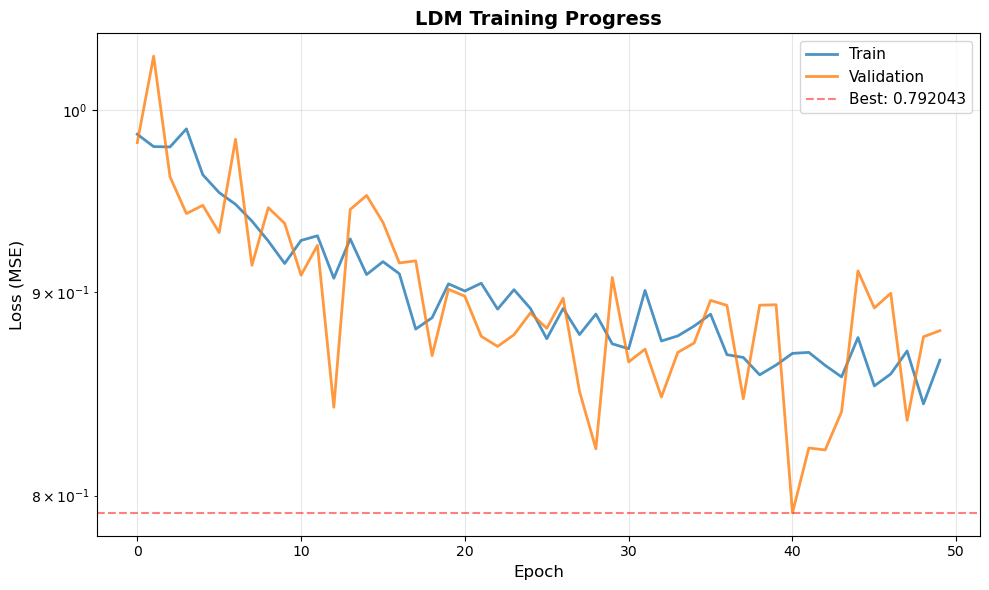

In [9]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(history.train_losses, label='Train', linewidth=2, alpha=0.8)
ax.plot(history.val_losses, label='Validation', linewidth=2, alpha=0.8)
ax.axhline(y=history.best_val_loss, color='red', linestyle='--', 
           alpha=0.5, label=f'Best: {history.best_val_loss:.6f}')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('LDM Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 8. Load Best Model

Load the saved checkpoint using `desisky.io.load`.

In [10]:
from pathlib import Path

# Path to saved model
save_dir = Path.home() / ".cache" / "desisky" / "saved_models" / "ldm"
save_path = save_dir / f"{config.run_name}.eqx"

# Load model and metadata
loaded_ldm, loaded_metadata = load(save_path, constructor=make_UNet1D_cond)

print("✓ Model loaded successfully!")
print(f"\nModel Metadata:")
print(f"  Training date: {loaded_metadata['training']['date']}")
print(f"  Best epoch: {loaded_metadata['training']['epoch']}")
print(f"  Validation loss: {loaded_metadata['training']['val_loss']:.6f}")
print(f"\nArchitecture:")
for key, val in loaded_metadata['arch'].items():
    print(f"  {key}: {val}")

✓ Model loaded successfully!

Model Metadata:
  Training date: 2026-02-12T12:49:31.895412
  Best epoch: 40
  Validation loss: 0.792043

Architecture:
  in_ch: 1
  out_ch: 1
  meta_dim: 8
  hidden: 32
  levels: 3
  emb_dim: 32


## 9. Generate Samples

Use the `LatentDiffusionSampler` to generate sky spectra.

In [11]:
# Create sampler with loaded model
# conditioning_scaler auto-normalizes raw metadata values to match training distribution
sampler = LatentDiffusionSampler(
    ldm_model=loaded_ldm,
    vae_model=vae,
    sigma_data=loaded_metadata["training"]["sigma_data"],
    conditioning_scaler=loaded_metadata["training"]["conditioning_scaler"],
    num_steps=250,        # More steps = higher quality (Heun solver)
    latent_channels=1,
    latent_dim=8,
)

# Get raw conditioning from validation indices
# Note: the sampler auto-normalizes using the conditioning_scaler
val_conditioning = conditioning[val_idx[:5]]

print("Generating samples...")
generated_spectra = sampler.sample(
    key=jr.PRNGKey(456),
    conditioning=jnp.array(val_conditioning),
    guidance_scale=1.0   # guidance_scale=1.0 matches training validation
)

print(f"Generated {len(generated_spectra)} spectra")
print(f"  Shape: {generated_spectra.shape}")

Generating samples...
Generated 5 spectra
  Shape: (5, 7781)


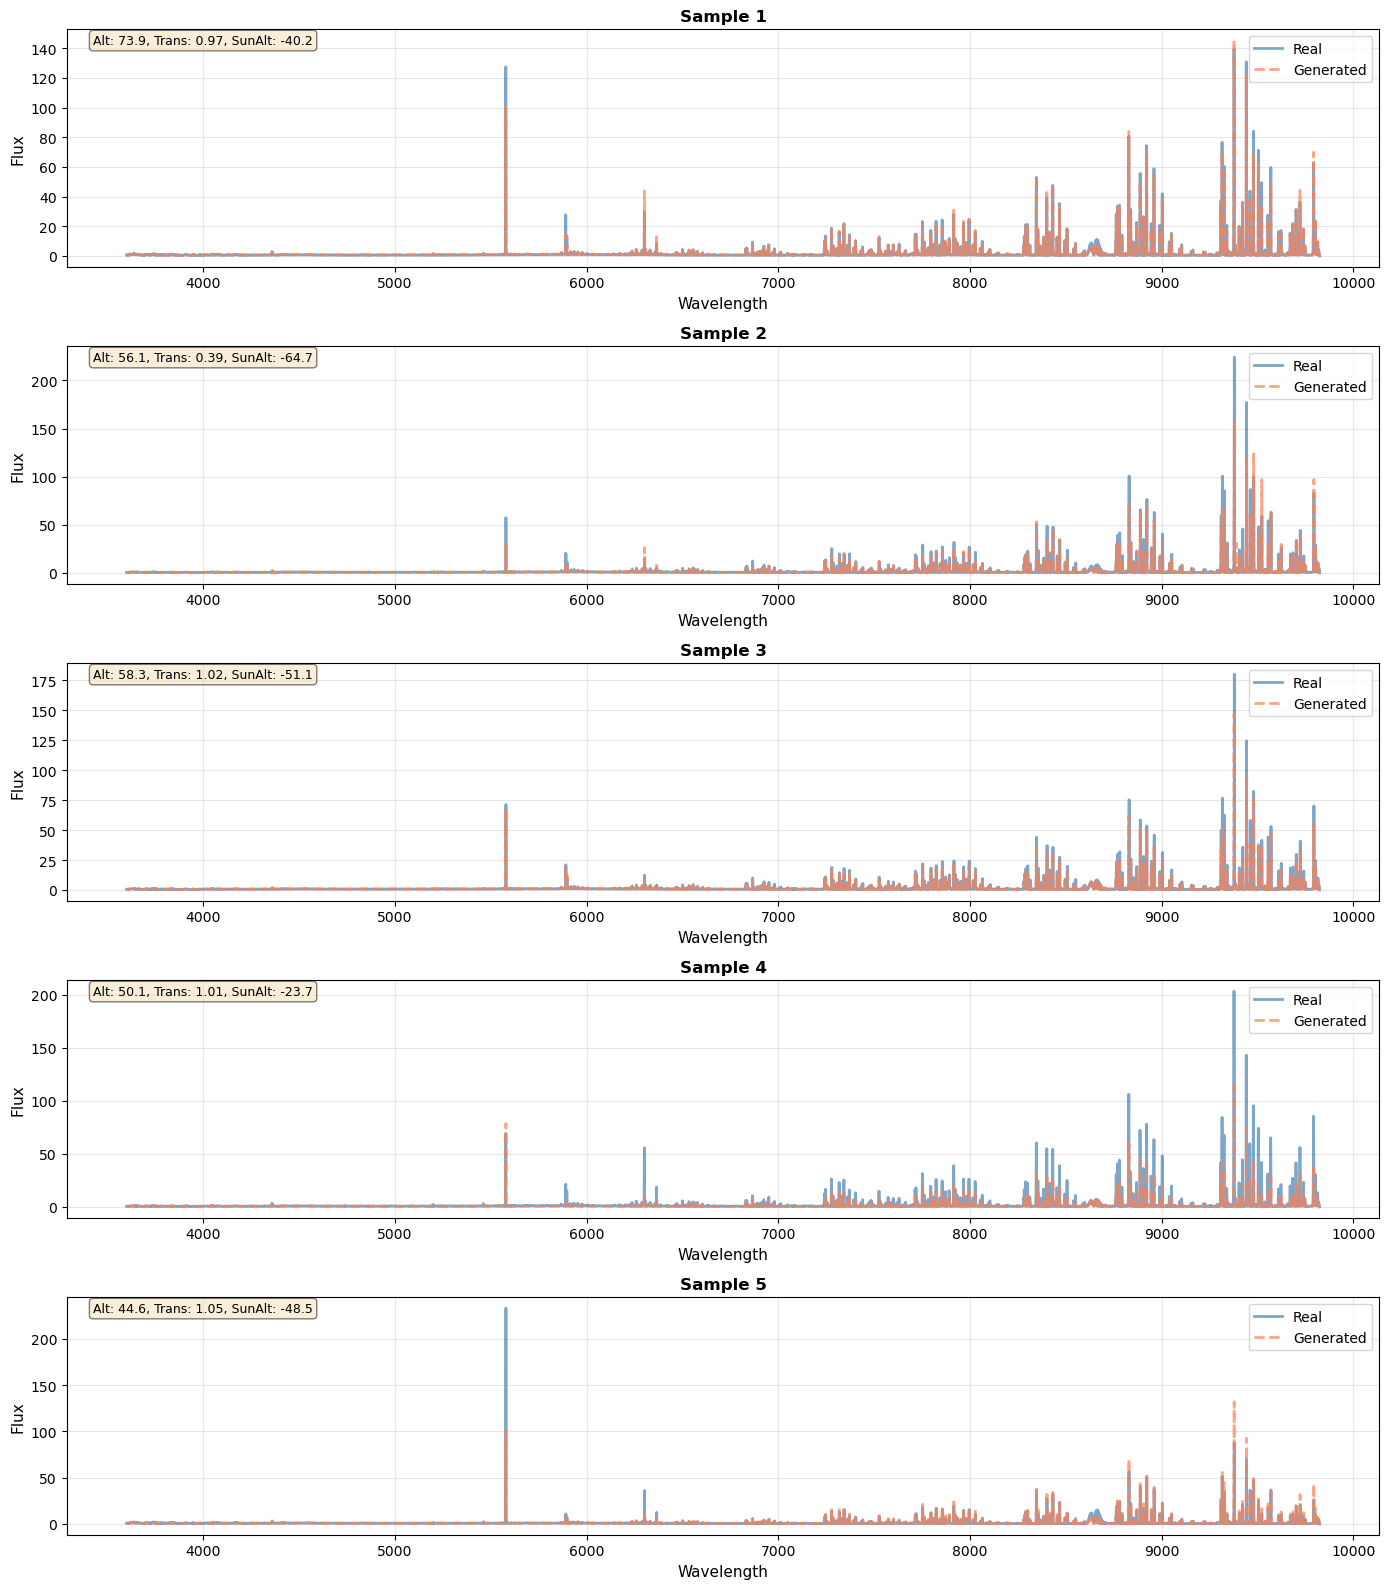

In [12]:
# Visualize generated vs real spectra
fig, axes = plt.subplots(5, 1, figsize=(14, 16))

for i, ax in enumerate(axes):
    real = flux[val_idx[i]]
    generated = generated_spectra[i]
    
    ax.plot(wavelength, real, label='Real', linewidth=2, alpha=0.7, color='steelblue')
    ax.plot(wavelength, generated, label='Generated', 
            linewidth=2, alpha=0.7, linestyle='--', color='coral')
    
    # Show conditioning values
    cond_str = (
        f"Alt: {val_conditioning[i][0]:.1f}, "
        f"Trans: {val_conditioning[i][1]:.2f}, "
        f"SunAlt: {val_conditioning[i][2]:.1f}"
    )
    ax.text(0.02, 0.98, cond_str, transform=ax.transAxes,
            verticalalignment='top', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Wavelength', fontsize=11)
    ax.set_ylabel('Flux', fontsize=11)
    ax.set_title(f'Sample {i+1}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Alternative: Training a Moon Model

To train a model for moon-contaminated sky spectra instead of dark-time, you only need to change:
1. Data loading method
2. Conditioning variables
3. Model configuration (meta_dim)

Below are the key changes needed. Uncomment and run these cells instead of the dark-time training above.

### Step 1: Load Moon-Contaminated Data

Replace the dark-time data loading (cell 4) with:

In [13]:
# MOON MODEL: Load moon-contaminated subset instead of dark-time
vac = SkySpecVAC(version="v1.0", download=True, verify=True)

# Load moon-contaminated subset with enrichment
wavelength, flux, metadata = vac.load_moon_contaminated(enrich=True)

print(f"Moon-contaminated subset: {len(metadata)} exposures")
print(f"Flux shape: {flux.shape}")

# Attach additional metadata (solar flux not as critical for moon model)
metadata = attach_solar_flux(metadata, time_tolerance="12h")
metadata = add_galactic_coordinates(metadata)
metadata = add_ecliptic_coordinates(metadata)

print(f"\nEnriched metadata columns: {len(metadata.columns)} total")

Moon-contaminated subset: 1931 exposures
Flux shape: (1931, 7781)
Matched solar-flux values for 1931 / 1931 exposures (tolerance = 12h).

Enriched metadata columns: 29 total


### Step 2: Use Moon-Specific Conditioning Variables

Replace the conditioning columns (cell 6) with:

In [14]:
# MOON MODEL: Define moon-specific conditioning columns
MOON_CONDITIONING_COLS = [
    "OBSALT",           # Observation altitude
    "TRANSPARENCY_GFA", # Atmospheric transparency
    "SUNALT",           # Sun altitude (still nighttime)
    "MOONALT",          # Moon altitude (KEY: moon position)
    "MOONSEP",          # Moon separation from observation (KEY)
    "MOONFRAC",         # Moon illumination fraction (KEY)
]

conditioning = metadata[MOON_CONDITIONING_COLS].to_numpy(dtype=np.float32)

# Remove rows with NaN or Inf values
finite_mask = np.isfinite(conditioning).all(axis=1)
n_bad = (~finite_mask).sum()

if n_bad > 0:
    print(f"⚠️  Removing {n_bad} rows with NaN/Inf values")
    flux = flux[finite_mask]
    conditioning = conditioning[finite_mask]
    metadata = metadata.loc[finite_mask].reset_index(drop=True)

print(f"\nConditioning shape: {conditioning.shape}")
print(f"Number of conditioning features: {len(MOON_CONDITIONING_COLS)}")
print(f"Conditioning columns: {MOON_CONDITIONING_COLS}")


Conditioning shape: (1931, 6)
Number of conditioning features: 6
Conditioning columns: ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'MOONALT', 'MOONSEP', 'MOONFRAC']


### Step 2.5: Encode Moon Flux and Recreate Data Loaders

**IMPORTANT**: After loading moon-contaminated data (cell 27) and defining moon conditioning (cell 29), you need to:
1. **Re-encode the moon flux** with the VAE to get moon latents
2. **Create new data loaders** using moon latents + moon conditioning (6 features)

Do NOT reuse the dark-time latents from cell 8 - those are encoded from different observations!

In [15]:
# MOON MODEL: Re-encode moon flux with VAE and create data loaders
print("Encoding moon-contaminated spectra to latent space...")
vae_inference = eqx.nn.inference_mode(vae)
results_moon = vae_inference(flux, jr.PRNGKey(42))
latents_moon = results_moon['latent']

print(f"Moon latent shape: {latents_moon.shape}")
print(f"Moon conditioning shape: {conditioning.shape}")
assert latents_moon.shape[0] == conditioning.shape[0]

# Add channel dimension
latents_moon_with_channel = np.array(latents_moon[:, None, :])

# --- Reproducible train/val index split (90/10) ---
dataset_size_moon = len(latents_moon_with_channel)
train_size_moon = int(0.9 * dataset_size_moon)

rng_moon = np.random.default_rng(42)
indices_moon = rng_moon.permutation(dataset_size_moon)
train_idx_moon = indices_moon[:train_size_moon]
val_idx_moon = indices_moon[train_size_moon:]

# --- Extract val_expids ---
val_expids_moon = metadata.iloc[val_idx_moon]["EXPID"].tolist()

# --- Fit conditioning scaler on TRAINING data only ---
scaler_dict_moon = fit_conditioning_scaler(conditioning[train_idx_moon], MOON_CONDITIONING_COLS)
cond_train_moon = normalize_conditioning(conditioning[train_idx_moon], scaler_dict_moon)
cond_val_moon = normalize_conditioning(conditioning[val_idx_moon], scaler_dict_moon)

# --- Compute sigma_data from TRAINING latents ---
sigma_data_moon = compute_sigma_data(latents_moon_with_channel[train_idx_moon])
print(f"sigma_data (moon): {sigma_data_moon:.6f}")

# --- Create TensorDatasets ---
train_set_moon = TensorDataset(
    torch.from_numpy(latents_moon_with_channel[train_idx_moon].astype(np.float32)),
    torch.from_numpy(cond_train_moon.astype(np.float32)),
)
val_set_moon = TensorDataset(
    torch.from_numpy(latents_moon_with_channel[val_idx_moon].astype(np.float32)),
    torch.from_numpy(cond_val_moon.astype(np.float32)),
)

batch_size = 64
train_loader_moon = NumpyLoader(train_set_moon, batch_size=batch_size, shuffle=True)
val_loader_moon = NumpyLoader(val_set_moon, batch_size=batch_size, shuffle=False)

print(f"\nMoon model data loaders created:")
print(f"  Training set: {len(train_set_moon):,} samples ({len(train_loader_moon)} batches)")
print(f"  Validation set: {len(val_set_moon):,} samples ({len(val_loader_moon)} batches)")
print(f"  Conditioning features: {conditioning.shape[1]}")

Encoding moon-contaminated spectra to latent space...
Moon latent shape: (1931, 8)
Moon conditioning shape: (1931, 6)
sigma_data (moon): 6.789327

Moon model data loaders created:
  Training set: 1,737 samples (28 batches)
  Validation set: 194 samples (4 batches)
  Conditioning features: 6


### Step 3: Update Model meta_dim

When creating the model (cell 13), use `meta_dim=6` instead of `meta_dim=8`:

In [16]:
# MOON MODEL: Create model with meta_dim=6 (6 conditioning features)
ldm_moon = make_UNet1D_cond(
    in_ch=1,                              # 1 channel for latent
    out_ch=1,                             # Predict 1 channel of noise
    meta_dim=6,                           # CHANGED: 6 features for moon model
    hidden=32,                            # Base channels
    levels=3,                             # U-Net depth
    emb_dim=32,                           # Embedding dimension
    key=jr.PRNGKey(0)
)

print("Moon LDM Architecture:")
print(f"  Input/Output channels: 1")
print(f"  Conditioning features: 6 (OBSALT, TRANS, SUNALT, MOONALT, MOONSEP, MOONFRAC)")
print(f"  Hidden channels: 32")
print(f"  U-Net levels: 3")

Moon LDM Architecture:
  Input/Output channels: 1
  Conditioning features: 6 (OBSALT, TRANS, SUNALT, MOONALT, MOONSEP, MOONFRAC)
  Hidden channels: 32
  U-Net levels: 3


### Step 4: Update Training Configuration

When configuring the trainer (cell 15), update `meta_dim` and checkpoint name:

In [17]:
# MOON MODEL: Configure training with meta_dim=6
config_moon = LDMTrainingConfig(
    epochs=50,
    learning_rate=1e-4,
    meta_dim=6,                                   # Must match moon model
    sigma_data=sigma_data_moon,                   # EDM: std of moon training latents
    dropout_p=0.1,
    print_every=5,
    validate_every=1,
    save_best=True,
    run_name="ldm_moon_v1",
    val_expids=val_expids_moon,
    conditioning_scaler=scaler_dict_moon,
)

# Create trainer with moon model
trainer_moon = LatentDiffusionTrainer(ldm_moon, config_moon)

print("Moon model training configuration:")
print(f"  Epochs: {config_moon.epochs}")
print(f"  Learning rate: {config_moon.learning_rate}")
print(f"  Meta dim: {config_moon.meta_dim} (6 moon features)")
print(f"  sigma_data: {config_moon.sigma_data:.6f}")
print(f"  Checkpoint: {config_moon.run_name}.eqx")

Moon model training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Meta dim: 6 (6 moon features)
  sigma_data: 6.789327
  Checkpoint: ldm_moon_v1.eqx


### Step 5: Train the Moon Model

The training loop remains the same (cell 16):

In [18]:
# MOON MODEL: Train the model using MOON data loaders
print("Starting moon model training...\n")
trained_ldm_moon, ema_model_moon, history_moon = trainer_moon.train(train_loader_moon, val_loader_moon)

print(f"\nMoon model training complete!")
print(f"  Best validation loss: {history_moon.best_val_loss:.6f} (epoch {history_moon.best_epoch})")

Starting moon model training...

  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1_ema.eqx
Epoch    0/50 | Train: 0.998417 | Val: 1.010801 | Best: 1.010801
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1_ema.eqx
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1_ema.eqx
Epoch    5/50 | Train: 0.987373 | Val: 0.963253 | Best: 0.929107
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_moon_v1_ema.eqx
Epoch   10/50 | Train: 0.961564 | Val: 0.969519 | Best: 0.916185
Epoch   15/50 | Train: 0.933539 | Val: 0.950100 | Best: 0.916185
  Saved checkpoint:

## Training a Twilight Model

To train a model for twilight (sun-contaminated) sky spectra instead of dark-time or moon, you only need to change:
1. Data loading method
2. Conditioning variables
3. Model configuration (meta_dim)

Below are the key changes needed for a twilight model.

### Step 1: Load Twilight Data

Replace the dark-time data loading with:

In [19]:
# TWILIGHT MODEL: Load twilight (sun-contaminated) subset
vac_twilight = SkySpecVAC(version="v1.0", download=True, verify=True)

# Load twilight subset with enrichment
wavelength_twi, flux_twi, metadata_twi = vac_twilight.load_sun_contaminated(enrich=True)

print(f"Twilight subset: {len(metadata_twi)} exposures")
print(f"Flux shape: {flux_twi.shape}")

# Attach additional metadata
metadata_twi = attach_solar_flux(metadata_twi, time_tolerance="12h")
metadata_twi = add_galactic_coordinates(metadata_twi)
metadata_twi = add_ecliptic_coordinates(metadata_twi)

print(f"\nEnriched metadata columns: {len(metadata_twi.columns)} total")

Twilight subset: 298 exposures
Flux shape: (298, 7781)
Matched solar-flux values for 295 / 298 exposures (tolerance = 12h).

Enriched metadata columns: 29 total


### Step 2: Use Twilight-Specific Conditioning Variables

Replace the conditioning columns with:

In [20]:
# TWILIGHT MODEL: Define twilight-specific conditioning columns
TWILIGHT_CONDITIONING_COLS = [
    "OBSALT",           # Observation altitude
    "TRANSPARENCY_GFA", # Atmospheric transparency
    "SUNALT",           # Sun altitude (KEY: sun position for twilight)
    "SUNSEP",           # Sun separation from observation (KEY)
]

conditioning_twi = metadata_twi[TWILIGHT_CONDITIONING_COLS].to_numpy(dtype=np.float32)

# Remove rows with NaN or Inf values
finite_mask_twi = np.isfinite(conditioning_twi).all(axis=1)
n_bad_twi = (~finite_mask_twi).sum()

if n_bad_twi > 0:
    print(f"⚠️  Removing {n_bad_twi} rows with NaN/Inf values")
    flux_twi = flux_twi[finite_mask_twi]
    conditioning_twi = conditioning_twi[finite_mask_twi]
    metadata_twi = metadata_twi.loc[finite_mask_twi].reset_index(drop=True)

print(f"\nConditioning shape: {conditioning_twi.shape}")
print(f"Number of conditioning features: {len(TWILIGHT_CONDITIONING_COLS)}")
print(f"Conditioning columns: {TWILIGHT_CONDITIONING_COLS}")


Conditioning shape: (298, 4)
Number of conditioning features: 4
Conditioning columns: ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'SUNSEP']


### Step 2.5: Encode Twilight Flux and Create Data Loaders

**IMPORTANT**: After loading twilight data, you need to:
1. **Re-encode the twilight flux** with the VAE to get twilight latents
2. **Create new data loaders** using twilight latents + twilight conditioning (4 features)

In [21]:
# TWILIGHT MODEL: Re-encode twilight flux with VAE and create data loaders
print("Encoding twilight spectra to latent space...")
vae_inference = eqx.nn.inference_mode(vae)
results_twi = vae_inference(flux_twi, jr.PRNGKey(42))
latents_twi = results_twi['latent']

print(f"Twilight latent shape: {latents_twi.shape}")
print(f"Twilight conditioning shape: {conditioning_twi.shape}")
assert latents_twi.shape[0] == conditioning_twi.shape[0]

# Add channel dimension
latents_twi_with_channel = np.array(latents_twi[:, None, :])

# --- Reproducible train/val index split (90/10) ---
dataset_size_twi = len(latents_twi_with_channel)
train_size_twi = int(0.9 * dataset_size_twi)

rng_twi = np.random.default_rng(42)
indices_twi = rng_twi.permutation(dataset_size_twi)
train_idx_twi = indices_twi[:train_size_twi]
val_idx_twi = indices_twi[train_size_twi:]

# --- Extract val_expids ---
val_expids_twi = metadata_twi.iloc[val_idx_twi]["EXPID"].tolist()

# --- Fit conditioning scaler on TRAINING data only ---
scaler_dict_twi = fit_conditioning_scaler(conditioning_twi[train_idx_twi], TWILIGHT_CONDITIONING_COLS)
cond_train_twi = normalize_conditioning(conditioning_twi[train_idx_twi], scaler_dict_twi)
cond_val_twi = normalize_conditioning(conditioning_twi[val_idx_twi], scaler_dict_twi)

# --- Compute sigma_data from TRAINING latents ---
sigma_data_twi = compute_sigma_data(latents_twi_with_channel[train_idx_twi])
print(f"sigma_data (twilight): {sigma_data_twi:.6f}")

# --- Create TensorDatasets ---
train_set_twi = TensorDataset(
    torch.from_numpy(latents_twi_with_channel[train_idx_twi].astype(np.float32)),
    torch.from_numpy(cond_train_twi.astype(np.float32)),
)
val_set_twi = TensorDataset(
    torch.from_numpy(latents_twi_with_channel[val_idx_twi].astype(np.float32)),
    torch.from_numpy(cond_val_twi.astype(np.float32)),
)

batch_size = 64
train_loader_twi = NumpyLoader(train_set_twi, batch_size=batch_size, shuffle=True)
val_loader_twi = NumpyLoader(val_set_twi, batch_size=batch_size, shuffle=False)

print(f"\nTwilight model data loaders created:")
print(f"  Training set: {len(train_set_twi):,} samples ({len(train_loader_twi)} batches)")
print(f"  Validation set: {len(val_set_twi):,} samples ({len(val_loader_twi)} batches)")
print(f"  Conditioning features: {conditioning_twi.shape[1]}")

Encoding twilight spectra to latent space...
Twilight latent shape: (298, 8)
Twilight conditioning shape: (298, 4)
sigma_data (twilight): 6.743656

Twilight model data loaders created:
  Training set: 268 samples (5 batches)
  Validation set: 30 samples (1 batches)
  Conditioning features: 4


### Step 3: Update Model meta_dim

When creating the model, use `meta_dim=4` instead of `meta_dim=8` or `meta_dim=6`:

In [22]:
# TWILIGHT MODEL: Create model with meta_dim=4 (4 conditioning features)
ldm_twilight = make_UNet1D_cond(
    in_ch=1,                              # 1 channel for latent
    out_ch=1,                             # Predict 1 channel of noise
    meta_dim=4,                           # CHANGED: 4 features for twilight model
    hidden=32,                            # Base channels
    levels=3,                             # U-Net depth
    emb_dim=32,                           # Embedding dimension
    key=jr.PRNGKey(0)
)

print("Twilight LDM Architecture:")
print(f"  Input/Output channels: 1")
print(f"  Conditioning features: 4 (OBSALT, TRANS, SUNALT, SUNSEP)")
print(f"  Hidden channels: 32")
print(f"  U-Net levels: 3")

Twilight LDM Architecture:
  Input/Output channels: 1
  Conditioning features: 4 (OBSALT, TRANS, SUNALT, SUNSEP)
  Hidden channels: 32
  U-Net levels: 3


### Step 4: Update Training Configuration

When configuring the trainer, update `meta_dim` and checkpoint name:

In [23]:
# TWILIGHT MODEL: Configure training with meta_dim=4
config_twilight = LDMTrainingConfig(
    epochs=50,
    learning_rate=1e-4,
    meta_dim=4,                                     # Must match twilight model
    sigma_data=sigma_data_twi,                      # EDM: std of twilight training latents
    dropout_p=0.1,
    print_every=5,
    validate_every=1,
    save_best=True,
    run_name="ldm_twilight_v1",
    val_expids=val_expids_twi,
    conditioning_scaler=scaler_dict_twi,
)

# Create trainer with twilight model
trainer_twilight = LatentDiffusionTrainer(ldm_twilight, config_twilight)

print("Twilight model training configuration:")
print(f"  Epochs: {config_twilight.epochs}")
print(f"  Learning rate: {config_twilight.learning_rate}")
print(f"  Meta dim: {config_twilight.meta_dim} (4 twilight features)")
print(f"  sigma_data: {config_twilight.sigma_data:.6f}")
print(f"  Checkpoint: {config_twilight.run_name}.eqx")

Twilight model training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Meta dim: 4 (4 twilight features)
  sigma_data: 6.743656
  Checkpoint: ldm_twilight_v1.eqx


### Step 5: Train the Twilight Model

The training loop remains the same:

In [24]:
# TWILIGHT MODEL: Train the model using TWILIGHT data loaders
print("Starting twilight model training...\n")
trained_ldm_twilight, ema_model_twilight, history_twilight = trainer_twilight.train(train_loader_twi, val_loader_twi)

print(f"\nTwilight model training complete!")
print(f"  Best validation loss: {history_twilight.best_val_loss:.6f} (epoch {history_twilight.best_epoch})")

Starting twilight model training...

  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1_ema.eqx
Epoch    0/50 | Train: 1.103113 | Val: 1.138291 | Best: 1.138291
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1_ema.eqx
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1_ema.eqx
Epoch    5/50 | Train: 0.996274 | Val: 1.081831 | Best: 0.984785
  Saved checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1.eqx
  Saved EMA checkpoint: /home/mdowicz/.cache/desisky/saved_models/ldm/ldm_twilight_v1_ema.eqx
Epoch   10/50 | Train: 0.991318 | Val: 0.870741 | Best: 0.870741
Epoch   15/50 | Train: 0.996270 | Val: 0.977893 

### Summary: Changes for Different LDM Models

| Aspect | Dark Model | Moon Model | Twilight Model |
|--------|-----------|------------|----------------|
| **Data loading** | `vac.load_dark_time()` | `vac.load_moon_contaminated()` | `vac.load_sun_contaminated()` |
| **Conditioning variables** | 8 features: OBSALT, TRANS, SUNALT, SOLFLUX, ECLLON, ECLLAT, GALLON, GALLAT | 6 features: OBSALT, TRANS, SUNALT, MOONALT, MOONSEP, MOONFRAC | 4 features: OBSALT, TRANS, SUNALT, SUNSEP |
| **Model meta_dim** | `meta_dim=8` | `meta_dim=6` | `meta_dim=4` |
| **Config meta_dim** | `meta_dim=8` | `meta_dim=6` | `meta_dim=4` |
| **Checkpoint name** | `ldm_dark_v1.eqx` | `ldm_moon_v1.eqx` | `ldm_twilight_v1.eqx` |
| **Everything else** | ✓ Same | ✓ Same | ✓ Same |

**Key insight**: The model architecture and training code are fully generic - you only change:
1. Data source (dark/moon/twilight subset)
2. Number of conditioning features (meta_dim)
3. Which features to use for conditioning

This makes it easy to train models for different sky conditions!